# Draw your own geophysics

Example notebook that extracts profiles and areas from Australia-wide grav & mag datasets, together with local petrophysics data, dtm profile and geological profile.

Very slow to access data at the moment, will look into ways of speeding up this part of process.

Requires GA geophys_utils code and map2loop-2 code

In [1]:
%matplotlib inline

In [2]:
import os
import netCDF4
import numpy as np
from geophys_utils import NetCDFGridUtils
from geophys_utils import get_netcdf_edge_points, points2convex_hull
import matplotlib.pyplot as plt

In [3]:
max_bytes = 500000000

netcdf_path = "https://dapds00.nci.org.au//thredds/dodsC/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/national_geophysical_compilations/Gravmap2019/Gravmap2019-grid-grv_cscba_1vd.nc"
netcdf_dataset = netCDF4.Dataset(netcdf_path, 'r')

netcdf_path_mag ="https://dapds00.nci.org.au/thredds/dodsC/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/national_geophysical_compilations/Magmap2019/Magmap2019-grid-tmi-Cellsize40m-AWAGS_MAG_2019.nc"
netcdf_dataset_mag = netCDF4.Dataset(netcdf_path_mag, 'r')


netcdf_grid_utils = NetCDFGridUtils(netcdf_dataset)
netcdf_grid_utils_mag = NetCDFGridUtils(netcdf_dataset_mag)



In [4]:
import folium
import pandas as pd
import json
import random
from shapely.geometry import Polygon
from ipyleaflet import Map, basemaps, GeoJSON, LayersControl, DrawControl,WMSLayer, GeoData, FullScreenControl, ScaleControl
from ipywidgets import Label
from ipywidgets import Label
import ipywidgets as widgets
import geopandas as gpd

test_data_name='Draw Your Own'

if(not test_data_name =='Draw Your Own'):
    if(test_data_name=='Last Area Drawn'):
        last_coords=pd.read_csv('../scratch/last_area.csv')
        display(last_coords)
        minx=last_coords.iloc[0]['minx']
        miny=last_coords.iloc[0]['miny']
        maxx=last_coords.iloc[0]['maxx']
        maxy=last_coords.iloc[0]['maxy']
    elif(not test_data_name =='Draw Your Own'):
        y_point_list = [miny, miny, maxy, maxy, maxy]
        x_point_list = [minx, maxx, maxx, minx, minx]
        bbox_geom = Polygon(zip(x_point_list, y_point_list))
        polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom])
        polygon_ll=polygon.to_crs(src_crs)

        minx=polygon_ll.total_bounds[0]
        maxx=polygon_ll.total_bounds[2]
        miny=polygon_ll.total_bounds[1]
        maxy=polygon_ll.total_bounds[3]

        minlong=minx
        maxlong=maxx
        minlat=miny
        maxlat=maxy
        #print("x",polygon_ll.total_bounds[0])
        st_bbox=[minlong,minlat,maxlong,maxlat]
        lat_point_list = [minlat, minlat, maxlat, maxlat,maxlat]
        lon_point_list = [minlong, maxlong, maxlong, minlong, minlong]
        bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
        rect = gpd.GeoDataFrame(index=[0], crs=src_crs, geometry=[bbox_geom]) 

    
    src_crs = "epsg:4326"  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
    dst_crs = "epsg:28350"  # coordinate reference system for imported dtms (geodetic lat/long WGS84)

    bbox2=str(minx)+","+str(miny)+","+str(maxx)+","+str(maxy)
    y_point_list = [miny, miny, maxy, maxy, maxy]
    x_point_list = [minx, maxx, maxx, minx, minx]
    bbox_geom = Polygon(zip(x_point_list, y_point_list))
    polygon = gpd.GeoDataFrame(index=[0], crs=dst_crs, geometry=[bbox_geom])
    polygon_ll=polygon.to_crs(src_crs)

    minlong=polygon_ll.total_bounds[0]
    maxlong=polygon_ll.total_bounds[2]
    minlat=polygon_ll.total_bounds[1]
    maxlat=polygon_ll.total_bounds[3]
    
    minlong=minx
    maxlong=maxx
    minlat=miny
    maxlat=maxy

    lat_point_list = [minlat, minlat, maxlat, maxlat,maxlat]
    lon_point_list = [minlong, maxlong, maxlong, minlong, minlong]
    bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
    rect = gpd.GeoDataFrame(index=[0], crs=src_crs, geometry=[bbox_geom]) 

    example_rect = GeoData(geo_dataframe = rect,
                   style={'color': 'purple', 'opacity':3, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},                  
                   name = 'Example')
    center=(minlat+((maxlat-minlat)/2),minlong+((maxlong-minlong)/2))
else:
    center=(-22.6,117.3)
    
wms_density = WMSLayer(
    url='https://geo.loop-gis.org/geoserver/loop/wms?',
    layers='loop:bulkdensitypoint_4326',
    format='image/png',
    transparent=True,
    attribution='density data from GA',
    name='density'

)
wms_magsus = WMSLayer(
    url='https://geo.loop-gis.org/geoserver/loop/wms?',
    layers='loop:magneticsusceptibility_4326b',
    format='image/png',
    transparent=True,
    attribution='magsus data from GA',
    name='magsus'

)
wms_geol = WMSLayer(
    url='https://geo.loop-gis.org/geoserver/loop/wms?',
    layers='loop:2_5m_interpgeop15_4326',
    format='image/png',
    transparent=True,
    opacity=0.4,
    attribution='Geology data from GSWA',
    name='geology'
)
wms_faults = WMSLayer(
    url='https://geo.loop-gis.org/geoserver/loop/wms?',
    layers='loop:gswa_2_5m_interpstrucl15',
    format='image/png',
    transparent=True,
    opacity=0.4,
    attribution='Linear features data from GSWA',
    name='faults/folds'
)

m =Map(basemap=basemaps.OpenTopoMap, center=center, zoom=8,scroll_wheel_zoom=True)
label = Label()
display(label)

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        label.value = str(kwargs.get('coordinates'))

m.on_interaction(handle_interaction)
m.add_layer(wms_geol)
m.add_layer(wms_faults)
m.add_layer(wms_density)
m.add_layer(wms_magsus)
if( not test_data_name =='Draw Your Own'):
    m.add_layer(example_rect)

    


m.add_control(LayersControl())
m.add_control(FullScreenControl())
m.add_control(ScaleControl(position='topright'))

dc = DrawControl(rectangle={'shapeOptions': {'color': '#0000FF'}})
m.add_control(dc)
m

Label(value='')

Map(center=[-22.6, 117.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [5]:
polyclip=False # implemented in future version

if(test_data_name=='Draw Your Own' or test_data_name=='Last Area Drawn'):
    if(test_data_name=='Draw Your Own'):
        src_crs = "epsg:4326"  # coordinate reference system for imported dtms (geodetic lat/long WGS84)
        dst_crs = "epsg:28350" # coordinate system for example data
        
        new_poly=GeoJSON(data=dc.last_draw)
        
        flat_list = [item for sublist in new_poly.data['geometry']['coordinates'] for item in sublist]
        print(flat_list)

[122.866501, -21.393463, 121.839146, -22.600541]


In [6]:
# Obtain coordinates for sample points along transect
# Note that sample points between vertices are computed in UTM space for linear metres

transect_vertices = ((flat_list[0],flat_list[1]),(flat_list[2],flat_list[3]))

sample_points, sample_spacing = netcdf_grid_utils.sample_transect(transect_vertices, 'EPSG:4326')
sample_points_mag, sample_spacing_mag = netcdf_grid_utils_mag.sample_transect(transect_vertices, 'EPSG:4326')
#print(sample_spacing,sample_spacing_mag)
sample_points = np.array(sample_points)
sample_points_mag = np.array(sample_points_mag)
#print(sample_points.shape,sample_points_mag.shape,)
#print(sample_points)

In [7]:
# Obtain values for sample points
import time
t0=time.time()
sample_values = np.array(netcdf_grid_utils.get_value_at_coords(sample_points, 'EPSG:4326', max_bytes=100))
t1=time.time()
sample_values_mag = np.array(netcdf_grid_utils_mag.get_value_at_coords(sample_points_mag, 'EPSG:4326', max_bytes=100))
t2=time.time()
print('grav',sample_points.shape[0],t1-t0,'mag',sample_points_mag.shape[0],t2-t1)
#print(sample_values.shape)

grav 342 109.72999906539917 mag 3412 1758.4583337306976


In [8]:
no_data_value = netcdf_grid_utils.data_variable._FillValue
good_data_mask = sample_values != no_data_value

good_sample_points = sample_points[good_data_mask]
bad_sample_points = sample_points[~good_data_mask]

sample_values[~good_data_mask] = np.NaN

no_data_value_mag = netcdf_grid_utils_mag.data_variable._FillValue
good_data_mask_mag = sample_values_mag != no_data_value_mag

good_sample_points_mag = sample_points_mag[good_data_mask_mag]
bad_sample_points_mag = sample_points_mag[~good_data_mask_mag]

sample_values_mag[~good_data_mask_mag] = np.NaN

In [9]:
from shapely.geometry import Point,Polygon
from geopandas import GeoDataFrame
from math import floor

if(flat_list[0]>flat_list[2]):
    minlong=flat_list[2]
    maxlong=flat_list[0]
else:
    minlong=flat_list[0]
    maxlong=flat_list[2]

if(flat_list[1]>flat_list[3]):
    minlat=flat_list[3]
    maxlat=flat_list[1]
else:
    minlat=flat_list[1]
    maxlat=flat_list[3]

lat_point_list = [minlat, minlat, maxlat, maxlat,maxlat]
lon_point_list = [minlong, maxlong, maxlong, minlong, minlong]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
mbbox = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[bbox_geom]) 
bbox=mbbox.total_bounds
mbbox=mbbox.to_crs('EPSG:28350')
    
bbox="{},{},{},{}".format(floor(mbbox.total_bounds[0]),floor(mbbox.total_bounds[1]),floor(mbbox.total_bounds[2]),floor(mbbox.total_bounds[3]))
geology_path='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:geol_500k&bbox={}&srs=EPSG:28350'.format(bbox)

geology = gpd.read_file(geology_path)
geology.crs='EPSG:28350'

l = [Point(i[0],i[1]) for i in sample_points_mag]
gdf = GeoDataFrame(np.zeros(sample_points_mag.shape[0]), crs='EPSG:4326', geometry=l)
gdf=gdf.to_crs('EPSG:28350')
geol_code = gpd.sjoin(gdf, geology, how="left", op="within")


<AxesSubplot:title={'center':'geol'}>

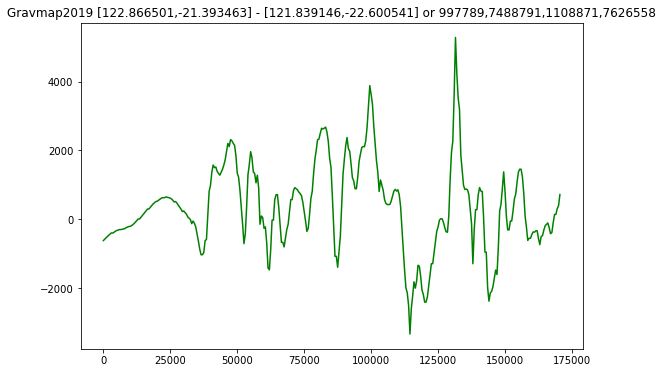

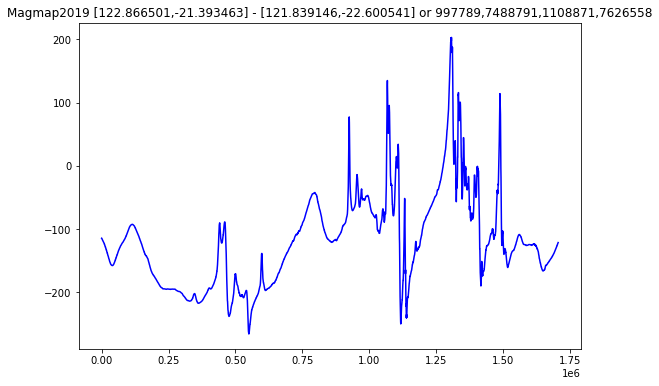

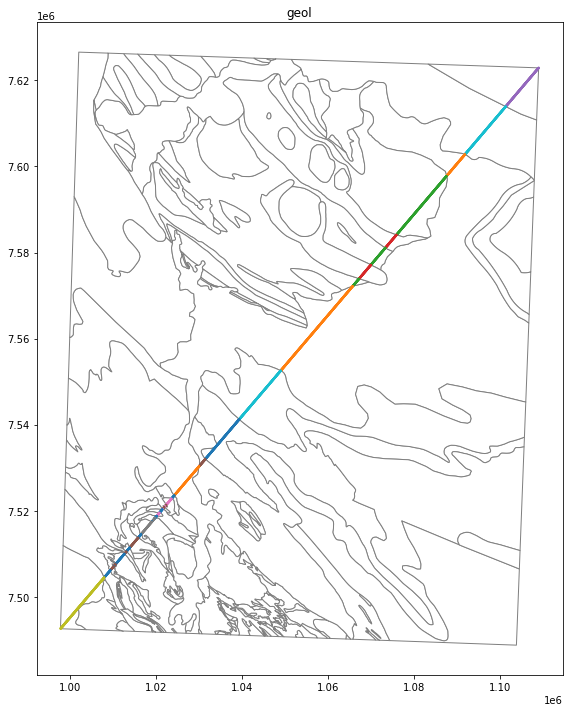

In [10]:
# Plot values against distance along transect
if sample_spacing >= 1000:
    x_increment = int(sample_spacing / 1000) # convert from m to km
else:
    x_increment = int(sample_spacing)
plt.figure(figsize=(9,6))   
plt.title('Gravmap2019 [{},{}] - [{},{}] or {}'.format(flat_list[0],flat_list[1],flat_list[2],flat_list[3],bbox))
plt.plot(range(0,len(sample_values) * x_increment, x_increment), sample_values, 'g-') # Show x in km

if sample_spacing >= 1000:
    x_increment = int(sample_spacing / 1000) # convert from m to km
else:
    x_increment = int(sample_spacing)
plt.figure(figsize=(9,6))    
plt.title('Magmap2019 [{},{}] - [{},{}] or {}'.format(flat_list[0],flat_list[1],flat_list[2],flat_list[3],bbox))

plt.plot(range(0,len(sample_values_mag) * x_increment, x_increment), sample_values_mag, 'b-') # Show x in km

geol_clip = gpd.overlay(geology, mbbox, how='intersection')

base=geol_clip.plot(edgecolor='gray',color='w',figsize=(18, 12))
plt.title('geol')
geol_code.plot(ax=base, column='descriptn', markersize=2)

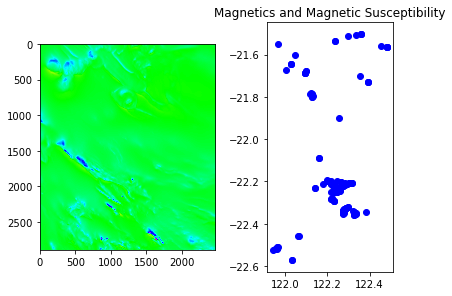

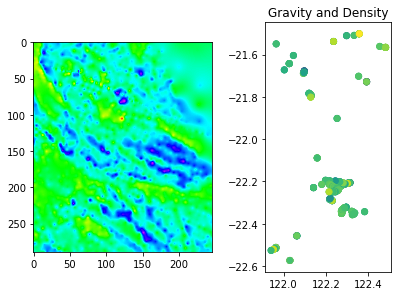

In [11]:
import map2loop.SpaceTime as st
bbox=[minlong,minlat,maxlong,maxlat]
density_filename='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:bulkdensitypoint_4326&srs=EPSG:4326'
mag_sus_filename='http://geo.loop-gis.org/geoserver/loop/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=loop:magneticsusceptibility_4326b&srs=EPSG:4326'
mag_netcdf_path ="https://dapds00.nci.org.au/thredds/dodsC/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/national_geophysical_compilations/Magmap2019/Magmap2019-grid-tmi-Cellsize40m-AWAGS_MAG_2019.nc"
grav_netcdf_path = "https://dapds00.nci.org.au//thredds/dodsC/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/national_geophysical_compilations/Gravmap2019/Gravmap2019-grid-grv_cscba_1vd.nc"
st.plot_mag_mag_sus(mag_netcdf_path,mag_sus_filename,bbox)
st.plot_grav_density(grav_netcdf_path,density_filename,bbox)


In [12]:
from owslib.wcs import WebCoverageService
url="http://services.ga.gov.au/gis/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?"
dtm_file='./dtm.tif'
bbox = (minlong-.1, minlat-.1, maxlong+.1, maxlat+.1)
wcs = WebCoverageService(url, version='1.0.0')

cvg = wcs.getCoverage(identifier='1',  bbox=bbox,
            format='GeoTIFF', crs=4326, width=200, height=200)
f = open(dtm_file, 'wb')
bytes_written = f.write(cvg.read())
f.close()
print("dtm geotif saved as", dtm_file)

dtm geotif saved as ./dtm.tif


<AxesSubplot:title={'center':'dtm'}>

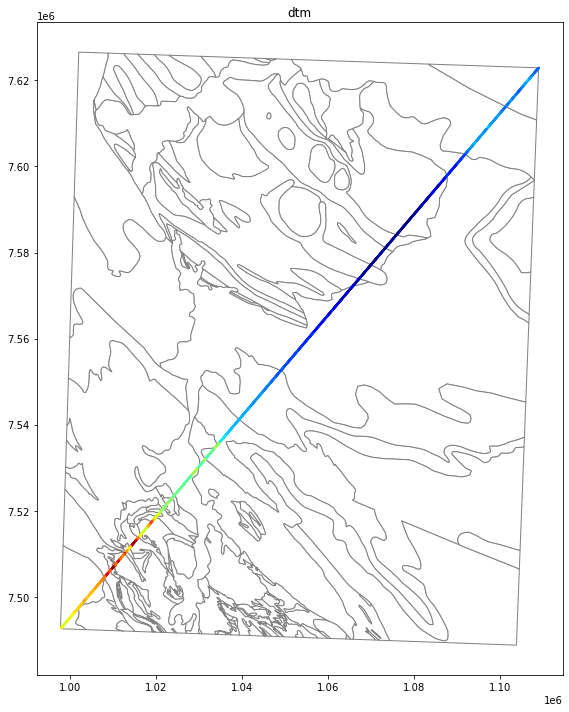

In [13]:
import rasterio
from map2loop.m2l_utils import value_from_raster
with rasterio.open(dtm_file) as dtm:
    band1 = dtm.read(1)
        
    dtm_data=[]
    for loc in sample_points_mag[1:-2]:
        locations=[(loc)]
        height=float(value_from_raster(dtm, locations))
        dtm_data.append([height])
        
l = [Point(i[0],i[1]) for i in sample_points_mag]
df=pd.DataFrame(dtm_data)
dtm_profile = gpd.GeoDataFrame(index=np.arange(len(sample_points_mag)), crs=src_crs, geometry=l) 
dtm_profile['dtm']=df
dtm_profile=dtm_profile[~dtm_profile['dtm'].isna()]
dtm_profile=dtm_profile.to_crs('EPSG:28350')
base=geol_clip.plot(edgecolor='gray',color='w',figsize=(18, 12))
plt.title('dtm')

dtm_profile.plot(ax=base, column='dtm', markersize=2,cmap='jet')